In [88]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display, HTML
import matplotlib.pyplot as plt  # Don't forget this import
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

In [89]:
from astropy.io import fits, ascii
from lvmdap.dap_tools import list_columns,read_DAP_file
from lvmdap.dap_tools import read_PT,scatter
from matplotlib import use as mpl_use

from astropy.table import Table,join
from astropy.table import vstack as vstack_table
#from lvmdap.cmaps_CLC import vel_map_CLC
import re
from collections import Counter

import matplotlib.colors as mpl_colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt  # Don't forget this import
from matplotlib import rcParams as rc
rc.update({'font.size': 12,\
           'font.weight': 900,\
           'text.usetex': True,\
           'path.simplify'           :   True,\
           'xtick.labelsize' : 12,\
           'ytick.labelsize' : 12,\
#           'xtick.major.size' : 3.5,\
#           'ytick.major.size' : 3.5,\
           'axes.linewidth'  : 2.0,\
               # Increase the tick-mark lengths (defaults are 4 and 2)
           'xtick.major.size'        :   6,\
           'ytick.major.size'        :   6,\
           'xtick.minor.size'        :   3,\
           'ytick.minor.size'        :   3,\
           'xtick.major.width'       :   1,\
           'ytick.major.width'       :   1,\
           'lines.markeredgewidth'   :   1,\
           'legend.numpoints'        :   1,\
           'xtick.minor.width'       :   1,\
           'ytick.minor.width'       :   1,\
           'legend.frameon'          :   False,\
           'legend.handletextpad'    :   0.3,\
           'font.family'    :   'serif',\
           'mathtext.fontset'        :   'stix',\
           'axes.facecolor' : "w",\
           
          })


In [90]:
#%matplotlib widget
#import matplotlib
#matplotlib.use('WebAgg')

%matplotlib notebook

def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

def get_slice_img(data,wave,w0=6555,w1=6570):
    i0=find_nearest(wave,w0)
    i1=find_nearest(wave,w1)
    print(i0,i1)
    slice_img=np.mean(data[:,i0:i1],axis=1)*1e15   
    return slice_img

def map_plot(ax,tab_DAP,line='flux_Halpha_6562.85', \
                 vmin=0, vmax=0, title=None, filename='junk',\
                 cmap='Spectral', fsize=5, figs_dir='.',fig_type='png',\
                 gamma=1.0, sf=1.0, tab_pt=None):
    
    X=tab_DAP['ra']
    Y=tab_DAP['dec']
    C=tab_DAP[line]    
    if (title== None):
        title=line.replace("_"," ")
        title=line.replace("_"," ")
    if (vmin==vmax):
        vmin=np.nanmin(C)
        vmax=np.nanmax(C)
    print(line,vmin,vmax)
#    fig,ax = plt.subplots(1,1,figsize=(fsize,fsize))
    norm=mpl_colors.PowerNorm(vmin=vmin,vmax=vmax,gamma=gamma)
    scat=scatter(X, Y, ax, size=sf*35.6/3600, c=C, cmap=cmap, norm=norm)
#    scat=scatter(X, Y, ax, size=35.6/3600, c=C,vmin = vmin, vmax = vmax, cmap=cmap, norm=colors.PowerNorm(gamma=gamma))
    ax.set_xlabel('Ra [deg]',fontsize=12)
    ax.set_ylabel('Dec [deg]',fontsize=12)
    xx = ax.get_xlim()
    ax.set_xlim(xx[1],xx[0])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(scat.sc, cax=cax,label=fr'{title}')#,fontsize=21)
    if (tab_pt != None):
        for tap_pt_now in tab_pt:
            ax.text(tab_pt['ra'],tab_pt['dec'],tab_pt['id'])
    return scat.sc,ax


def plot_spec_dap(dir='output/',file='output.m_lvmSCFrame-00006109.fits.gz',\
              name='none',cmap=None,\
              x_min=3600,x_max=9400,y_min=-0.2,y_max=2,text='',\
              file_ssp = 'output/m_lvmSCFrame-00006109',no_st=False,no_model=False,log=False,\
             id_lines=None,output='junk.pdf',c_map='carlos',do_legend=True, insets=None,y0_d=0.5,y1_d=2.5):
    tab_SSP=read_rsp_dap(file_ssp)
    
    if (cmap==None):
        color_cm_now = vel_map_CLC()
        cmap=color_cm_now
    file=dir+'/'+file
    hdu=fits.open(file)
    data=hdu[0].data
    (ny,nx)=data.shape
#    data=np.mean(data,axis=1)
    i0 = int(nx*0.45)
    i1 = int(nx*0.55)

    data = data / np.median(data[0,i0:i1])
    hdr=hdu[0].header
    crval = hdr['crval1']
    cdelt = hdr['cdelt1']
    crpix = hdr['crpix1']
    #print(data.shape)
    (ny,nx) = data.shape
    wave = crval+cdelt*(np.arange(0,nx)-(crpix-1))
    fig = plt.figure(figsize=(19,6)) 
    gs = fig.add_gridspec(nrows=5, ncols=6,  left=0.075, right=0.97, \
                          hspace=0.0, wspace=0.05, bottom=0.15, top=0.99)
    ax0 = fig.add_subplot(gs[:-1, :])
    ax1 = fig.add_subplot(gs[-1:, :], sharex=ax0)   
    ax0.set_xlim(x_min,x_max)
    ax1.set_xlim(x_min,x_max)
    ax0.set_ylim(y_min,y_max)        

    #ax0 = fig.add_subplot()
    if (c_map=='carlos'):
        colors=color_cm_now(np.linspace(0,1,10))
    else:
        c_colors = mpl.colormaps[c_map].resampled(256)
        colors=c_colors(np.linspace(0,1,10))
        
    colors=['black','maroon','steelblue','darkorange','olive','grey']
    if (no_st==False):
        ax0.plot(wave,data[0,:],color=colors[0],alpha=1.0,linewidth=1.5,label=r'Observed (O$_\lambda$)')
        ax1.plot(wave,data[0,:],color=colors[0],alpha=1.0,linewidth=1.5)#,label=r'Observed (O$_\lambda$)')
        if (no_model==False):
            ax0.plot(wave,data[1,:],color=colors[1],alpha=1.0,label=r'Model (M$_\lambda$)')
            ax1.plot(wave,data[1,:],color=colors[1],alpha=1.0)#,label=r'Model (M$_\lambda$)')
    res = data[0,:]-data[1,:]
    gas_model = data[2,:]-data[1,:]
    ax0.plot(wave,res,color=colors[2],alpha=0.7,\
             label=r'Residual (O$_\lambda$-M$_\lambda$)',linewidth=3)
    if (no_model==False):
        ax0.plot(wave,gas_model,color=colors[3],alpha=0.7,\
                 label=r'Em. lines model')
    
    std_res = np.std(res[2000:2500])
    flux = np.median(data[1,2000:2500])
    ax1.axvspan(5650, 5850, alpha=0.7, color='grey',zorder=10)
    ax1.axvspan(7500, 7700, alpha=0.7, color='grey',zorder=10)
    

    ax0.xaxis.set_minor_locator(MultipleLocator(100))
    #ax0.axes.get_xaxis().set_visible(False)
    handles, labels = ax0.get_legend_handles_labels()
    if (do_legend):
        ax0.legend(handles, labels,loc=(0.8,0.5),frameon=True,handlelength=1.5,\
                   ncol=1,columnspacing=0.15, prop={'size': 22})
    x = np.arange(x_min,1.1*x_max,100)
    y1 = 5+0*x
    y0 = -5+0*x

    if (id_lines != None):
        colors=['darkred','firebrick','indianred']
        mask_lines = (id_lines['wl'].value>=x_min) & (id_lines['wl'].value<x_max)
        tab_elines = id_lines[mask_lines]
        even=0
        for line in tab_elines:
            ax0.text(line['wl'],y_max-0.16*(even+1)*(y_max-y_min),\
                     f"{line['wl']}",color=colors[even],\
                     fontsize='16',horizontalalignment='center',rotation='vertical')
            even=even+1
            if (even>2):
                even=0
        #print(tab_elines)
        
    if (insets != None):
        for inst in insets:
            #x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9  # subregion of the original image
            axins = ax0.inset_axes(
                [inst[0], inst[1], inst[2], inst[3]],
                xlim=(inst[4], inst[5]), ylim=(inst[6], inst[7]),yticklabels=[])#, xticklabels=[], yticklabels=[])
            if (no_st==False):
                axins.plot(wave,data[0,:],color=colors[0],alpha=1.0,linewidth=1.5,label=r'Observed (O$_\lambda$)')
            if (no_model==False):
                axins.plot(wave,data[1,:],color=colors[1],alpha=1.0,label=r'Model (M$_\lambda$)')
            axins.plot(wave,res,color=colors[2],alpha=0.7,\
                       label=r'Residual (O$_\lambda$-M$_\lambda$)',linewidth=3)
            if (no_model==False):
                axins.plot(wave,gas_model,color=colors[3],alpha=0.7,\
                           label=r'E. lines model')
            #axins.set_facecolor("white")
            ax0.indicate_inset_zoom(axins, edgecolor="black")

        
    ax0.set_ylabel(r'$<$O$_\lambda$/O$_{5500}$$>$', fontsize=23)
    ax0.text(x_min+0.05*(x_max-x_min),y_min+0.85*(y_max-y_min),text,fontsize=21)
    ax1.set_xlabel(r'rest-frame wavelength [\AA]', fontsize=23)
    ax1.set_ylim(y0_d,y1_d)
    if (log==True):
        ax0.set_yscale('log')
    plt.tight_layout()
    fig.savefig(output, transparent=False, facecolor='white', edgecolor='white')#.pdf")

def spec_plot(ax, wave, spec, e_spec=0,
              x_min=3550,x_max=9800,y_min=0,y_max=0):
    
    colors=['black','maroon','steelblue','darkorange','olive','grey']
    spec_plot=ax.plot(wave,spec,color=colors[0],linewidth=1.5,label=r'Observed (O$_\lambda$)')
    if (len(e_spec)>1):
        e_spec_plot=ax.plot(wave,e_spec,color=colors[1],linewidth=1.5)#,label=r'Observed (O$_\lambda$)')
    if (y_min==y_max):
        y_min=-0.5*np.median(spec)
        y_max=np.max(spec)
    ax.set_ylim(y_min,y_max)
    ax.set_xlim(x_min,x_max)
    return spec_plot,e_spec_plot


In [91]:
DIR_DRP = 'data'
lvmid='00006109'
cframe_file = f'data/lvmCFrame-{lvmid}.fits'
hdu=fits.open(cframe_file)
hdu.info()

Filename: data/lvmCFrame-00006109.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     301   ()      
  1  FLUX          1 ImageHDU        22   (12401, 1944)   float32   
  2  ERROR         1 ImageHDU         8   (12401, 1944)   float32   
  3  MASK          1 ImageHDU         8   (12401, 1944)   uint8   
  4  WAVE          1 ImageHDU         7   (12401,)   float32   
  5  FWHM          1 ImageHDU         8   (12401, 1944)   float32   
  6  SKY           1 ImageHDU         8   (12401, 1944)   float32   
  7  SKY_ERROR     1 ImageHDU         8   (12401, 1944)   float32   
  8  SUPERSKY      1 BinTableHDU     24   1458345R x 6C   [E, E, E, J, J, 4A]   
  9  SLITMAP       1 BinTableHDU     43   1944R x 17C   [K, K, 3A, K, 8A, 5A, K, 4A, D, D, D, 6A, 8A, K, 17A, K, K]   


In [92]:
tab_PT=read_PT(cframe_file,'None',nobad=False)
tab_PT.columns

<TableColumns names=('id','ra','dec','mask','fiberid','exposure')>

In [93]:
w0=6555
w1=6570
fib=int(len(tab_PT)/2)


In [94]:
slice_img=get_slice_img(hdu['FLUX'].data,hdu['WAVE'].data,w0,w1)
print(slice_img.shape)
tab_map=tab_PT
tab_map['flux']=slice_img
tab_map=tab_map[tab_map['mask']==1]


5910 5940
(1944,)


<IPython.core.display.Javascript object>


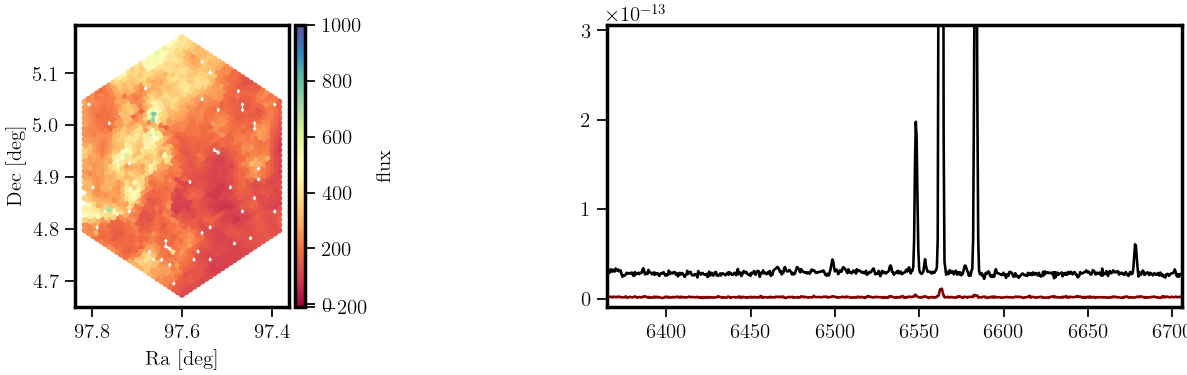

flux -10 1000


Button(description='Click Me!', style=ButtonStyle())

Output()

In [110]:
fsize=3.5
fig = plt.figure(figsize=(9.5, 3), layout="constrained")
spec = fig.add_gridspec(1, 7, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.4)
ax0 = fig.add_subplot(spec[0,0:2])
ax1 = fig.add_subplot(spec[0,2:7])
#annotate_axes(ax0, 'ax0')

sc,ax0=map_plot(ax0,tab_map,line='flux', \
                 vmin=-10, vmax=1000, title=None, filename='junk',\
             cmap='Spectral', fsize=fsize, figs_dir='figs')
global sp_y_min,sp_y_max,sp_x_min,sp_x_max,fib
sp_y_min=-0.5*np.median(hdu['FLUX'].data[fib,:])
sp_y_max=np.max(hdu['FLUX'].data[fib,:])
sp_x_min=3550
sp_x_max=9700
sp_p,e_sp_p=spec_plot(ax1,hdu['WAVE'].data,hdu['FLUX'].data[fib,:],hdu['ERROR'].data[fib,:],
                         x_min=sp_x_min,x_max=sp_x_max,y_min=sp_y_min,y_max=sp_y_max)

#text=ax0.text(np.max(tab_map['ra']),np.max(tab_map['dec']), "text", va="bottom", ha="left",fontsize=14)
text=ax1.text(ax1.get_xlim()[0]+0.025*(ax1.get_xlim()[1]-ax1.get_xlim()[0]),
              ax1.get_ylim()[1]-0.1*(ax1.get_ylim()[1]-ax1.get_ylim()[0]),
              f'{fib}', va="bottom", ha="left",fontsize=14)

button = widgets.Button(description="Click Me!")
output = widgets.Output()
display(button, output)

def on_button_clicked(b):
    with output:
        print("Button clicked.")

button.on_click(on_button_clicked)

def onclick(event):
    global sp_x_min,sp_x_max,fib
    dist = np.sqrt((tab_map['ra']-event.xdata)**2+(tab_map['dec']-event.ydata)**2)
    fib = np.argmin(dist)
    #sp_p.set_ydata(hdu['FLUX'].data[fib,:])
    #e_sp_p.set_ydata(hdu['ERROR'].data[fib,:])
    [l.remove() for l in ax1.lines]
    sp_p,e_sp_p=spec_plot(ax1,hdu['WAVE'].data,hdu['FLUX'].data[fib,:],hdu['ERROR'].data[fib,:],
                         x_min=sp_x_min,x_max=sp_x_max,y_min=sp_y_min,y_max=sp_y_max)
    tx = '%d,%f,%f' % (fib,event.xdata, event.ydata)
    text.set_text(tx)


    
    
def update_spec_range(change):
    global sp_x_min,sp_x_max,fib
    sp_x_min=change.new[0]
    sp_x_max=change.new[1]
    [l.remove() for l in ax1.lines]
    sp_p,e_sp_p=spec_plot(ax1,hdu['WAVE'].data,hdu['FLUX'].data[fib,:],hdu['ERROR'].data[fib,:],
                         x_min=sp_x_min,x_max=sp_x_max,y_min=sp_y_min,y_max=sp_y_max)
    #fig.canvas.draw()
    
int_range_slider = widgets.IntRangeSlider(
    value=(sp_x_min,sp_x_max), 
    min=sp_x_min, max=sp_x_max, step=hdu['WAVE'].data[1]-hdu['WAVE'].data[0], 
    description='Spectral range to plot',layout=widgets.Layout(width='100%')
)
  
# a VBox container to pack widgets vertically
#widgets.VBox(
#    [
#        int_range_slider, 
#    ]
#)    
int_range_slider.observe(update_spec_range, 'value')

cid = fig.canvas.mpl_connect('button_press_event', onclick)
widgets.VBox([int_range_slider])
#int_range_slider
    
    
#fig.tight_layout()

#fig

<IPython.core.display.Javascript object>


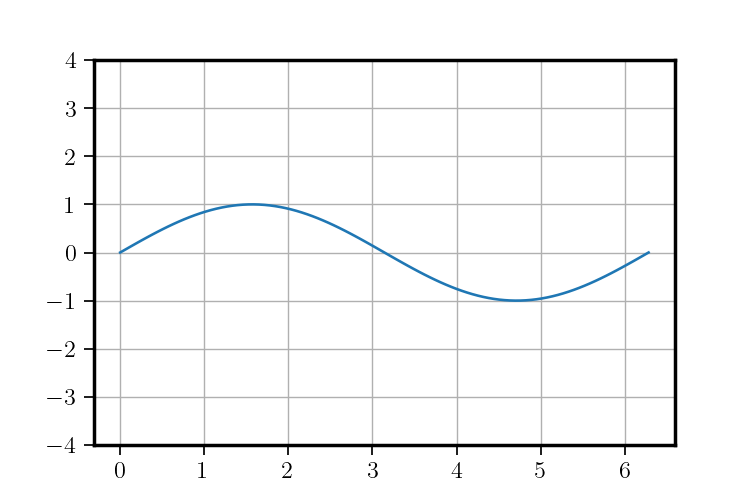

interactive(children=(IntSlider(value=1, description='w', max=10), FloatSlider(value=1.0, description='amp', m…

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_ylim([-4, 4])
ax.grid(True)
 
# generate x values
x = np.linspace(0, 2 * np.pi, 100)
 
 
def my_sine(x, w, amp, phi):
    """
    Return a sine for x with angular frequeny w and amplitude amp.
    """
    return amp*np.sin(w * (x-phi))
 
 
@widgets.interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi+0.01, 0.01))
def update(w = 1.0, amp=1, phi=0):
    """Remove old lines from plot and plot new one"""
    [l.remove() for l in ax.lines]
    ax.plot(x, my_sine(x, w, amp, phi), color='C0')